In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import data_catalog
import tseries_mod
import esmlab_wrap

In [2]:
data_catalog.set_catalog('experiments')

active catalog: experiments


In [3]:
varnames = ['SFCO2_LND', 'SFCO2_OCN']

In [4]:
experiment = 'esm-hist-cmip5'
esm_hist_cmip5 = tseries_mod.tseries_get_vars(varnames, 'atm', experiment, stream='cam2.h0')
esm_hist_cmip5_ann = esmlab_wrap.compute_ann_mean(esm_hist_cmip5)
print(esm_hist_cmip5_ann)

<xarray.Dataset>
Dimensions:    (region: 1, tbnd: 2, time: 156)
Coordinates:
  * region     (region) object 'Global'
  * time       (time) object 1850-07-01 17:00:00 ... 2005-07-01 17:00:00
Dimensions without coordinates: tbnd
Data variables:
    SFCO2_LND  (time, region) float64 1.71 -0.8664 -0.7786 ... -2.114 -0.7272
    time_bnds  (tbnd, time) object 1850-01-01 00:00:00 ... 2006-01-01 00:00:00
    co2vmr     (time) float64 0.0002848 0.0002849 ... 0.0003779 0.0003788
    ch4vmr     (time) float64 7.917e-07 7.931e-07 ... 1.754e-06 1.754e-06
    f11vmr     (time) float64 3.344e-11 3.346e-11 ... 7.056e-10 7.087e-10
    f12vmr     (time) float64 0.0 0.0 0.0 0.0 ... 5.4e-10 5.396e-10 5.394e-10
    n2ovmr     (time) float64 2.755e-07 2.756e-07 ... 3.191e-07 3.194e-07
    sol_tsi    (time) float64 1.361e+03 1.361e+03 ... 1.361e+03 1.361e+03
    SFCO2_OCN  (time, region) float64 -0.03372 -0.07409 0.1825 ... -2.413 -2.345
Attributes:
    history:  \n2019-06-19 07:19:16.809091 esmlab.resample(

In [5]:
experiment = 'esm-hist'
esm_hist = tseries_mod.tseries_get_vars(varnames, 'atm', experiment)
esm_hist_ann = esmlab_wrap.compute_ann_mean(esm_hist)
print(esm_hist_ann)

<xarray.Dataset>
Dimensions:    (nbnd: 2, region: 1, time: 165)
Coordinates:
  * region     (region) object 'Global'
  * time       (time) object 1850-07-01 17:00:00 ... 2014-07-01 17:00:00
Dimensions without coordinates: nbnd
Data variables:
    SFCO2_LND  (time, region) float64 1.01 1.256 -0.05728 ... -1.301 -0.3325
    time_bnds  (nbnd, time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
    co2vmr     (time) float64 0.0002843 0.0002845 ... 0.0003957 0.0003974
    ch4vmr     (time) float64 8.083e-07 8.085e-07 ... 1.823e-06 1.831e-06
    f11vmr     (time) float64 3.211e-11 3.211e-11 ... 8.011e-10 8.084e-10
    f12vmr     (time) float64 0.0 0.0 0.0 0.0 ... 5.257e-10 5.23e-10 5.208e-10
    n2ovmr     (time) float64 2.73e-07 2.731e-07 ... 3.26e-07 3.269e-07
    sol_tsi    (time) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    SFCO2_OCN  (time, region) float64 -0.05409 -0.03967 ... -2.534 -2.62
Attributes:
    history:  \n2019-06-19 07:19:24.403474 esmlab.resample(<DATA

In [6]:
# add cummulate flux vars to datasets
for ds in [esm_hist_cmip5_ann, esm_hist_ann]:
    for varname in ['SFCO2_LND', 'SFCO2_OCN']:
        da = ds[varname].cumsum(dim='time', keep_attrs=True)
        da.name = varname+'_CUM'
        da.attrs['units'] = 'Pg'
        ds[da.name] = da

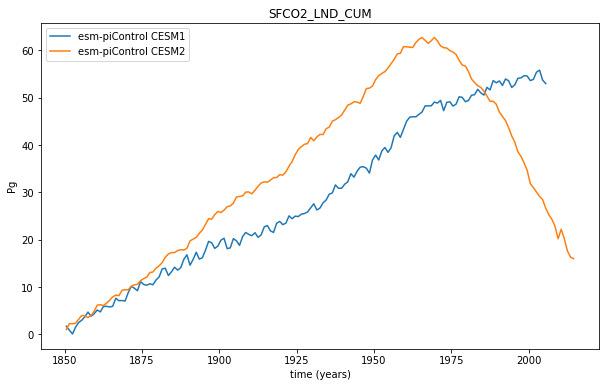

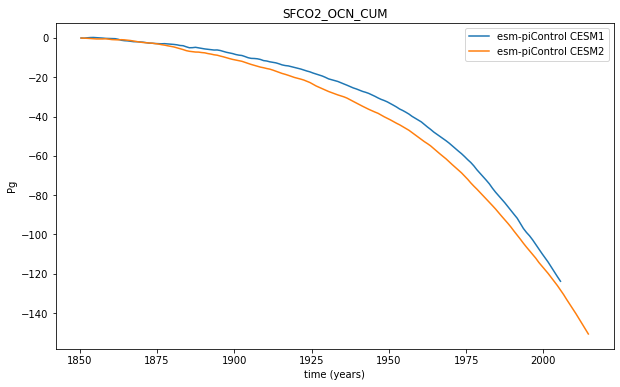

In [7]:
ds_list = [esm_hist_cmip5_ann, esm_hist_ann]
legend_list = ['esm-piControl CESM1', 'esm-piControl CESM2']
varname = 'SFCO2_LND_CUM'
tseries_mod.tseries_plot_1var(varname, ds_list, legend_list, varname, region_val='Global')
varname = 'SFCO2_OCN_CUM'
tseries_mod.tseries_plot_1var(varname, ds_list, legend_list, varname, region_val='Global')